In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import torch
import sys  
import os
sys.path.insert(0, '../../..')

from hnn.simulation.mve_ensemble import MveEnsembleMechanics
from hnn.simulation.mve_ensemble.viz import visualize_trajectory, plot_energy
from hnn.simulation.mve_ensemble.mve_ensemble import calc_kinetic_energy, get_initial_conditions
from hnn.train import train


In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--device', default="mps", type=str, help="device to run on")
    parser.add_argument('--batch_size', default=1000, type=int, help='batch size')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-5, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=3000, type=int, help='number of gradient steps')
    parser.add_argument('--n_bodies', default=4, type=int, help='number of particles')
    parser.add_argument('--n_dims', default=3, type=int, help='number of dimensions')
    parser.add_argument('--field_type', default='both', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

args = get_args()
torch.set_default_device(args.device)

In [3]:
mechanics = MveEnsembleMechanics()

In [4]:
def plot_energy_from_coords(r, v, time):
    pe = mechanics.no_bc_potential_fn(r.transpose(0, 1)).detach().cpu()
    ke = calc_kinetic_energy(v.transpose(0, 1), masses).detach().cpu()
    te = pe + ke

    plot_energy(pe, ke, te, time.cpu())

torch.Size([50, 4, 3]) torch.Size([50, 4, 3]) 50


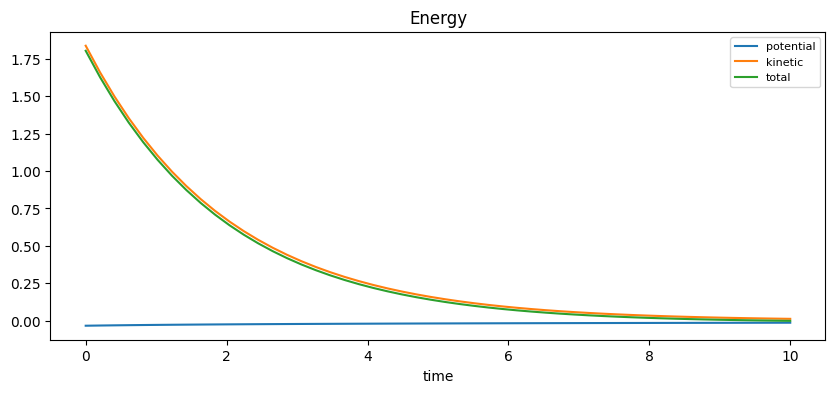

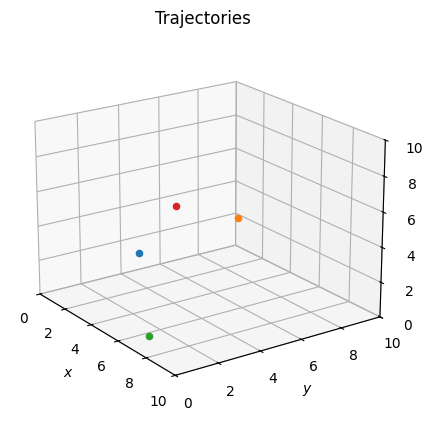

In [5]:
y0, masses = get_initial_conditions(args.n_bodies, args.n_dims)

r, v, dr, dv, time = mechanics.get_trajectory({ "y0": y0, "masses": masses }).dict().values()
plot_energy_from_coords(r, v, time)
ani = visualize_trajectory(r.transpose(0, 1).detach().cpu(), len(time), mechanics.domain)
HTML(ani.to_jshtml())

In [6]:
# load data
import os, pickle
pickle_path = 'mve_ensemble_data.pkl'

if os.path.exists(pickle_path):
    print(f"Loading data from {pickle_path}")
    with open(pickle_path, 'rb') as file:
        data = pickle.loads(file.read())
else:
    print("Creating data...")
    data = mechanics.get_dataset({}, { "y0": y0, "masses": masses })
    print(f"Saving data to {pickle_path}")
    with open(pickle_path, 'wb') as file:
        pickle.dump(data, file)

Creating data...


In [ ]:
# check data
data_r, data_v = [v.squeeze(-2) for v in torch.split(data["x"][0], 1, dim=-2)]
plot_energy_from_coords(data_r, data_v, data["time"])
ani = visualize_trajectory(data_r.transpose(0, 1), len(data["time"]), mechanics.domain)
HTML(ani.to_jshtml())

In [ ]:
# train model
model, stats = train(args, data)

In [ ]:
fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title("Loss")
plt.xlabel("time")
plt.plot(stats["train_loss"], label="train_loss")
plt.plot(stats["test_loss"], label="test_loss")
plt.legend(fontsize=8)

fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title("Zoomed-in final loss")
plt.xlabel("time")
plt.plot(stats["train_loss"][-500:], label="train_loss")
plt.plot(stats["test_loss"][-500:], label="test_loss")
plt.legend(fontsize=8)


In [ ]:
# plot model output

test_y0, test_masses = get_initial_conditions(args.n_bodies, args.n_dims)
initial_state = test_y0.clone().detach().requires_grad_()
r, v, dr, dv, time = mechanics.get_trajectory({"y0": initial_state, "masses": test_masses, "model": model}).dict().values()
plot_energy_from_coords(r, v, time)

ani_model = visualize_trajectory(r.transpose(0, 1), len(time), mechanics.domain)
HTML(ani_model.to_jshtml())